In [1]:
import gzip
import pandas as pd
import multiprocessing
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# sns.set_style("ticks")
from data_manipulation.reading_util import *

import os
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
def concat_ml_df(env_csv_enzymes:str, env_fasta_non_enzymes:str, length_plot:bool):
    """
    A method for merging our enzymes with non enzymes + adding labels.
    Important: Line 30 resizes non_enzymes df to match the size of enzymes, comment this line out if you have to

    :param env_csv_enzymes: Constant pointing to absolute path of enzymes splitX.csv in .env
    :param env_fasta_non_enzymes: Constant pointing to absolute path of non_emzyme splitX.fasta in .env
    :param length_plot: Optional length comparison
    :return: Df containing both positive and negative samples with labels
    """
    enzymes_path = os.getenv(env_csv_enzymes)
    non_enzymes_path = os.getenv(env_fasta_non_enzymes)

    enzymes = pd.read_csv(enzymes_path, sep=",")
    non_enzymes = read_fasta_to_df(non_enzymes_path)

    enzymes = filter_unwanted_seqs(df=enzymes, enzymes=True)
    enzymes.set_index("Entry", inplace=True)

    non_enzymes = filter_unwanted_seqs(df=non_enzymes, enzymes=False)
    print(len(non_enzymes))

    enzymes["Label"] = 1
    non_enzymes["Label"] = 0
    non_enzymes["EC number"] = 0


    # here I resize non_enzymes to match the size of enzymes
    non_enzymes = non_enzymes.sample(len(enzymes), random_state=42)

    print("Enzyme df size: ", len(enzymes))
    print("Non Enzyme df size: ", len(non_enzymes))

    # combine df to main dataframe for knn
    df = pd.concat([enzymes, non_enzymes])

    if length_plot:
        palette = {1: "tab:cyan", -1: "tab:orange"}
        sns.displot(df, x=df["Sequence"].apply(len), hue="Label", element="step", palette=palette, legend=False, bins=73)
        plt.legend(title='Label', loc='upper right', labels=['Enzyme', 'Non Enzyme'])
        plt.show()

    return df


## Methods used to classify samples based on the sequence length distribution

In [3]:
def pred_seq(sequence:str, inerval_dict: dict) -> int:
    """
    :param sequence: AA sequence
    :param inerval_dict: A dict containing each bin / interval [KEY] and the probability of a sequence in said interval being an enzyme
           [VALUE]
    :return: 1 means enzyme, -1 means non enzyme
    """
    for i in range(1, 15):
        if 73 * (i-1) <= len(sequence) <= i * 73:
            if random.random() <= inerval_dict[i]:
                return 1
            else:
                return -1


def get_length_dist(ml_df:pd.DataFrame) -> dict:
    """
    NOTE: There are some magic numbers here: our bins are 14 in total and each bin contains 73 seqs. These numbers have to be changed
    depending on how big the input df is.
    :param ml_df: df containing enzymes and non enzymes with the corresponding labels 1 and -1
    :return: a dict with intervals and the probability for a sequence being an enzyme in a given interval
    """
    temp_df = ml_df
    interval_dict = {}
    for i in range(1, 15):
        df_bin = temp_df[temp_df["Sequence"].apply(len) <= i * 73]
        temp_df = temp_df.drop(df_bin.index)
        total = len(df_bin)
        enzymes = len(df_bin[df_bin["Label"] == 1])
        # non_enzymes = total - enzymes
        prob_enzyme = enzymes / total
        interval_dict[i] = prob_enzyme
        # print(i, prob_enzyme)

    return interval_dict


37347
Enzyme df size:  9186
Non Enzyme df size:  9186


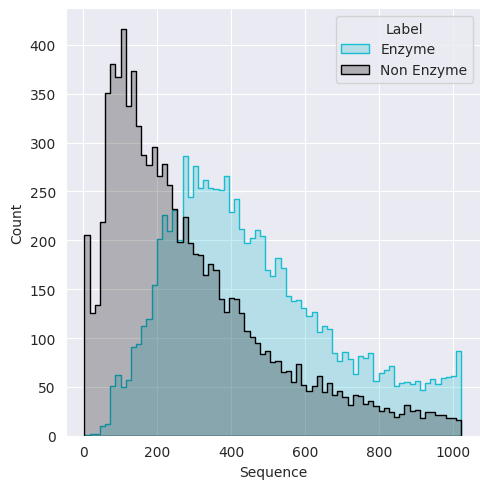

In [4]:

ml_df = concat_ml_df("CSV30_ENZYMES", "FASTA_NON_ENZYMES", True)

X_train, X_val, y_train, y_val = train_test_split(ml_df["Sequence"], ml_df["Label"], random_state=42, test_size=0.3)


train_x_list = X_train.tolist()
test_x_list = X_val.tolist()

NUM_PROCESSES = 16

# Creating ncd data (computationally very expensive)

In [14]:
def ncd(x:str, x2:str) -> float:
    """
    A method which takes in two seqs and calculates the normalized compression distance (ncd)
    :param x: Sequence 1
    :param x2: Sequence 2
    :return: Ncd
    """
    x_compressed = len(gzip.compress(x.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))
    xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
    return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

In [15]:
# Initialize NCD matrices
train_ncd = [[0] * len(train_x_list) for _ in range(len(train_x_list))]
test_ncd = [[0] * len(train_x_list) for _ in range(len(test_x_list))]

In [16]:
# Helper function to compute NCD row
def calculate_ncd_row(data_row): # data row is a tuple of (index, text)
    i = data_row[0] # index of the data and data_row[1] is the text data
    # calcs the row of NCD values for the given data sample
    row = [ncd(data_row[1], train_x_list[j]) for j in range(len(train_x_list))]
    return i, row # return index and row's ncd values

In [ ]:
with multiprocessing.Pool(NUM_PROCESSES) as pool:
    # Compute train NCD
    train_data = list(enumerate(train_x_list))
    train_results = pool.map(calculate_ncd_row, train_data)

    # Compute test NCD
    test_data = list(enumerate(test_x_list))
    test_results = pool.map(calculate_ncd_row, test_data)

In [13]:
# Insert rows into NCD matrices
for i, row in train_results:
    train_ncd[i] = row

for i, row in test_results:
    test_ncd[i] = row

# Write ncd distances to file for later use

In [16]:
if not os.path.exists("gzip_data"):
    os.mkdir("gzip_data")

f = open("gzip_data/train_ncd.txt", "w")
f.truncate()
for line in train_ncd:
    f.write(str(line))
    f.write()
f.close()

f = open("gzip_data/test_ncd.txt", "w")
f.truncate()
for line in test_ncd:
    f.write(str(line))
    f.write()
f.close()


# Read in computed ncd data

In [5]:
path_to_test_ncd = os.getenv("TEST_NCD")
path_to_train_ncd = os.getenv("TRAIN_NCD")

with open(path_to_test_ncd) as test_ncd_txt:
    test_ncd = []
    for line in test_ncd_txt:
        test_ncd.append(eval(line))

with open(path_to_train_ncd) as train_ncd_txt:
    train_ncd = []
    for line in train_ncd_txt:
        train_ncd.append(eval(line))


# Train KNN and compute ROC curve and AUC

In [13]:
# K = 15
# KNN classification
neigh = KNeighborsClassifier(n_neighbors=17)

neigh.fit(train_ncd, y_train)
accuracy = neigh.score(test_ncd, y_val)
predictions = neigh.predict(test_ncd)
print(len(predictions))
print(predictions[:10])
f1 = f1_score(y_val, predictions)

# Predict probabilities for the positive class (class 1)
y_prob = neigh.predict_proba(test_ncd)[:, 1]
print(len(y_prob))
print(y_prob[:10])

# Compute ROC curve and AUC for gzip_knn
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
mcc = matthews_corrcoef(y_val, predictions)
print(accuracy)
print(f1)
print(mcc)
# creates a csv file with the following structure:
# 1     fpr
# 2     tpr
# 3     roc_auc
# 4     accuracy
# 5     f1
# 6     MCC
# scores = open(f"gzip_data/{K}_scores.csv", "w")
# scores.truncate()
# fpr_list = [x for x in fpr]
# scores.write(str(fpr_list))
# scores.write("\n")
# tpr_list = [x for x in tpr]
# scores.write(str(tpr_list))
# scores.write("\n")
# scores.write(str(roc_auc))
# scores.write("\n")
# scores.write(str(accuracy))
# scores.write("\n")
# scores.write(str(f1))
# scores.write("\n")
# scores.write(str(mcc))
# scores.close()

5512
[0 1 1 1 1 0 1 1 1 1]
5512
[0.23529412 0.82352941 0.76470588 0.82352941 1.         0.17647059
 0.58823529 0.70588235 0.88235294 0.52941176]
0.7102685050798259
0.7369461373744028
0.4306776634489849


In [12]:
print(y_val[:10])

[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]


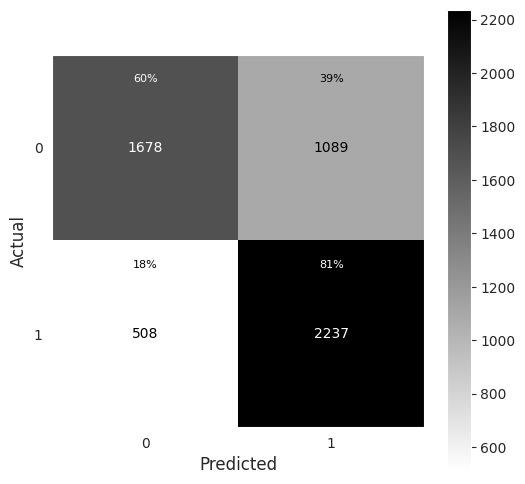

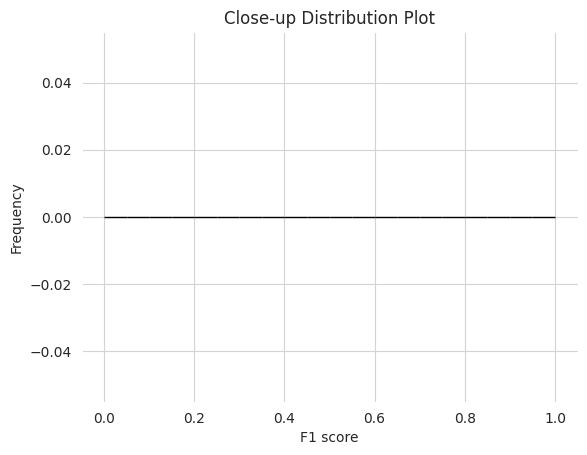

Multiclass CNN:
  - Initial F1 Score: 0.71
  - Mean ± SE: 0.71 ± 0.0062
  - 95% CI: [0.70, 0.72]


In [14]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

class_names = [0,1]
conf_matrix = confusion_matrix(y_val, predictions)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        # Increase the vertical offset for the percentage text
        offset = 0.4
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=8,
                fontweight='light', zorder=4)

# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)

plt.show()

import math
from sklearn.metrics import f1_score


def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)

        indices = indices.astype(int)  # Convert the indices to integers
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.80
    max_value = 0.87

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    plt.grid(color='lightgrey')
    plt.title('Close-up Distribution Plot')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)


def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)


def train_and_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

y_val = np.array(y_val)

initial_f1 = calculate_f1(y_val, predictions)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_val, predictions, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")


# Initialize random classifier based on length distribution

In [9]:
interval_dict = get_length_dist(ml_df)

# Initialize arrays to store all predicted scores and actual labels
all_pred_scores = []
all_actual_labels = []

for seq in ml_df["Sequence"]:
    pred = pred_seq(seq, inerval_dict=interval_dict)
    actual_label = ml_df[ml_df["Sequence"] == seq]["Label"][0]
    all_pred_scores.append(pred)
    all_actual_labels.append(actual_label)

# Calculate ROC curve and AUC for classifying samples based on their length
fpr_l, tpr_l, thresholds_l = roc_curve(all_actual_labels, all_pred_scores)
roc_auc_l = auc(fpr_l, tpr_l)


# Read in performance results

In [22]:
results = []
for K in [3, 5, 7, 9, 11, 13, 15, 17]:
    with open(f"gzip_data/{K}_scores.csv") as scores:
        lines = scores.readlines()
        fpr = eval(lines[0].lstrip("\n"))
        tpr = eval(lines[1].lstrip("\n"))
        roc_auc = float(lines[2].lstrip("\n"))
        accuracy = float(lines[3].lstrip("\n"))
        f1 = float(lines[4].lstrip("\n"))
        mcc = float(lines[5].lstrip("\n"))
        results.append([fpr, tpr, roc_auc, accuracy, f1, mcc])
        scores.close()


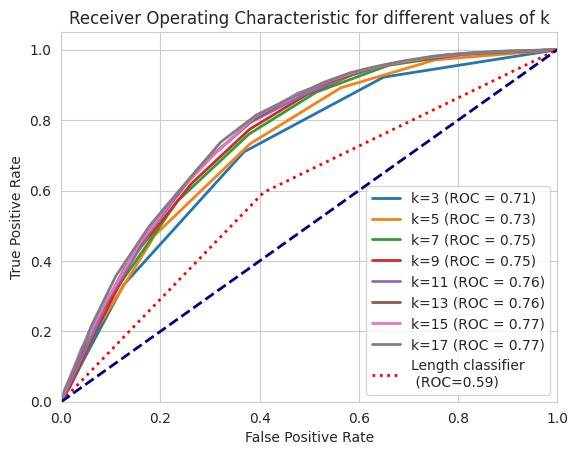

In [39]:
# Plot ROC curve
plt.figure()
k = 1

for res in results:
    k += 2
    plt.plot(res[0], res[1], lw=2, label=f'k={k} (ROC = %0.2f)' % res[2])
    # plt.plot(fpr_5, tpr_5, lw=2, label='k = 5 (ROC = %0.2f)' % auc_5)
plt.plot(fpr_l, tpr_l, color='red', lw=2, linestyle=":", label='Length classifier \n (ROC=%0.2f)' % roc_auc_l)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for different values of k')
plt.legend(loc="lower right")
plt.show()

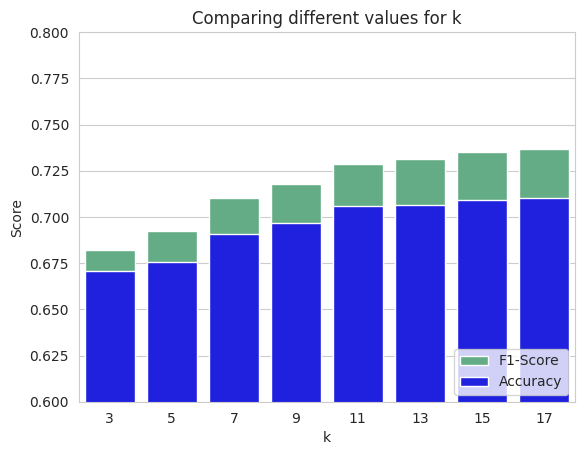

In [40]:
# Plot F1 and acc
ks = [3,5,7,9,11,13,15,17]
accuracies = []
f1_scores = []
for res in results:
    accuracies.append(res[3])
    f1_scores.append(res[4])

ax = plt.subplots()
# Create plots for F1-Score and Accuracy
ax = sns.barplot(x=ks, y=f1_scores, label='F1-Score',color="#57b884")
ax = sns.barplot(x=ks, y=accuracies, label='Accuracy', color="blue")

# Set plot title and labels
custom_ticks_y = np.arange(0.64, 0.8, 0.02)
ax.set_title("Comparing different values for k")
ax.legend(loc="lower right")
ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_ylim(0.6, 0.8)  # Adjust the limits as needed

# plt.yticks(custom_ticks_y)
# Show the plot
plt.show()


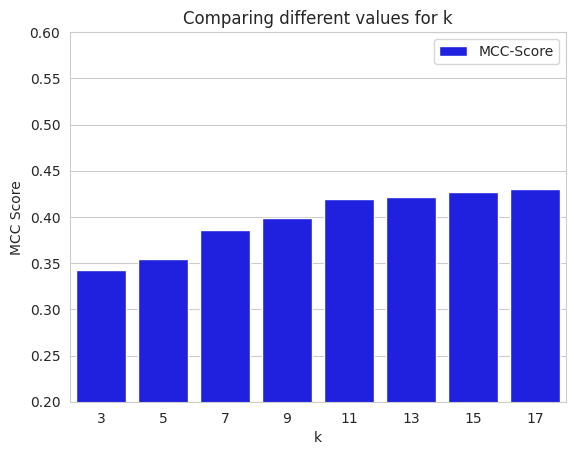

In [42]:
# plot mcc
ks = [3,5,7,9,11,13,15,17]
mcc_scores = []
for res in results:
    mcc_scores.append(res[5])

ax = plt.subplots()
ax = sns.barplot(x=ks, y=mcc_scores, label='MCC-Score', color="blue")

# Set plot title and labels
ax.set_title("Comparing different values for k")
ax.set_xlabel("k")
ax.set_ylabel("MCC Score")
ax.set_ylim(0.2,0.6)
ax.legend()

# Show the plot
plt.show()


# Looking into the sequence compression and distance calculation

In [7]:
x = "MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNYS"
print(f"SEQUENCE:\n---------\n{x}\nLENGTH: {len(x)}\n")
x_comp = gzip.compress(x.encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{x_comp}\n")
print(f"LENGTH: {len(x_comp)}")

SEQUENCE:
---------
MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNYS
LENGTH: 47

COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x0ee)e\x02\xff\x05\xc1\x81\t\x00 \x0c\x03\xb0\xdb\x86J\x15k\xd1M\x84\xfd\xff\x88\xc9rB\x96\x96e\xee8z\xe0d%\x1d\xdc\xc8\x87n7|\xc8\xd9t\xaa2>\xaa\x15A\x1d/\x00\x00\x00'

LENGTH: 63


In [8]:
x2 = "MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNYS"
print(f"SEQUENCE:\n---------\n{x2}\nLENGTH: {len(x2)}\n")
x2_comp = gzip.compress(x2.encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{x2_comp}\n")
print(f"LENGTH: {len(x2_comp)}")

SEQUENCE:
---------
MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNYS
LENGTH: 47

COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x0ee)e\x02\xff\x05\xc1\x81\t\x00 \x0c\x03\xb0\xdb\x86J\x15k\xd1M\x84\xfd\xff\x88\xc9rB\x96\x96e\xee8z\xe0d%\x1d\xdc\xc8\x87n7|\xc8\xd9t\xaa2>\xaa\x15A\x1d/\x00\x00\x00'

LENGTH: 63


In [12]:
my_test_string = "Enzyme Prediction Group 1"
print(len(my_test_string))
my_test_string_comp = gzip.compress(my_test_string.encode())
print(my_test_string_comp)
print(len(my_test_string_comp))

25
b"\x1f\x8b\x08\x00\xf1\xc5'e\x02\xffs\xcd\xab\xaa\xccMU\x08(JM\xc9L.\xc9\xcc\xcfSp/\xca/-P0\x04\x00(\x85\xed\x9e\x19\x00\x00\x00"
45


## Combining x and x2 to xx2

In [9]:
xx2_comp = gzip.compress(" ".join([x, x2]).encode())
print(len(" ".join([x, x2])))
print(f"COMPRESSED SEQUENCE:\n--------------------\n{xx2_comp}\n")
print(f"LENGTH: {len(xx2_comp)}")


95
COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x15e)e\x02\xff\xf3\r\xf2q\xf7s\x8ct\x8ct\xf6\x0e\x08\x0e\xf4\x0bs\xf7\xf1\xf6q\xf1\xf1\tr\xf7\tp\x8f\x0cs\xf7p\x0c\t\x0e\xf2\xf4\x0b\xf2q\xf5\x0bt\xf1\x8b\x0cV\xf0%M=\x00\xb2[\x1b\x9a_\x00\x00\x00'

LENGTH: 71


## Calulating normalized compression distances

In [10]:
# saving lengths
x_comp_length = len(x_comp)
x2_comp_length = len(x2_comp)
xx2_comp_length = len(xx2_comp)


ncd = (xx2_comp_length - min(x_comp_length, x2_comp_length)) / max(x_comp_length, x2_comp_length)
print(f"Normalized compression distance: {ncd}")

Normalized compression distance: 0.12698412698412698


### Now we need to compare every sequence to every other sequence in the dataframe:

In [63]:
def ncd(x, x2):
  x_compressed = len(gzip.compress(x.encode()))
  x2_compressed = len(gzip.compress(x2.encode()))
  xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
  return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

In [64]:
example_df = ml_df["Sequence"][1:10]
train_ncd = [[ncd(example_df[i], example_df[j]) for j in range(len(example_df))] for i in range(len(example_df))]

In [69]:
for i in range(len(train_ncd)):
    print(f"[{i}]: {train_ncd[i]}")

[0]: [0.04609929078014184, 0.900709219858156, 0.913312693498452, 0.9438669438669439, 0.9477124183006536, 0.9113475177304965, 0.9524714828897338, 0.8936170212765957, 0.8829787234042553]
[1]: [0.9078014184397163, 0.04285714285714286, 0.9256965944272446, 0.9584199584199584, 0.9651416122004357, 0.9142857142857143, 0.9524714828897338, 0.9071428571428571, 0.9]
[2]: [0.9164086687306502, 0.9256965944272446, 0.034055727554179564, 0.9584199584199584, 0.9564270152505446, 0.9287925696594427, 0.9562737642585551, 0.9071207430340558, 0.9009287925696594]
[3]: [0.9438669438669439, 0.9667359667359667, 0.9542619542619543, 0.037422037422037424, 0.9646569646569647, 0.9563409563409564, 0.9600760456273765, 0.9417879417879418, 0.9459459459459459]
[4]: [0.9477124183006536, 0.9651416122004357, 0.9586056644880174, 0.9667359667359667, 0.034858387799564274, 0.9455337690631809, 0.9657794676806084, 0.9498910675381264, 0.9368191721132898]
[5]: [0.9042553191489362, 0.9142857142857143, 0.9287925696594427, 0.96049896049

In [2]:
x = [0,1,2,3,4,5,6,7,8,9,10]
print(x[1:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9]


 Testing if our sequence length classifier method actually works:

In [8]:
interval_dict = get_length_dist(ml_df)
counter = 0
for i in range(10000):
    p = pred_seq("MYHPGRSPSFLITLANVICAAILFDIHTGGYQPGSLIPIVAWMTPFVTLLWLSASFATYLYKYVRTRLLPEEKVARVYYTAQSAPYFDPALGVMMQFAPSHGGASIEVQVNPSWISLLGGSLKINGDDASNESAVLGSFYSSVKPGDEPASLVAIKSGPQTIGFGCRTKIDGDDCLFTANHVWNNSMRPTALAKRGKQVAIEDWETPLSCDHKMLDFVVVRVPKHVWSKLGVKATQLVCPSDKDAVTCYGGSSSDNLLSGTGVCSKVDFSWKLTHSCPTAAGWSGTPIYSSRGVVGMHVGFEDIGKLNRGVNAFYVSNYLLRSQETLPPELSVIEIPFEDVETRSYEFIEVEIKGRGKAKLGKREFAWIPESGKYWADDDDDSLPPPPKVVDGKMVWSSAQETVAEPLNLPAGGRVKALAALSQLAGYDFKEGEAASTRGMPLRFVGQSACKFRELCRKDTPDEVLRATRVFPELSDFSWPERGSKAELHSLLLQAGKFNPTGIPRNLEGACQNLLERYPASKSCYCLRGEAWSFDAVYEEVCKKAQSAEINEKASPGVPLSRLASTNKDLLKRHLELVALCVTERLFLLSEAEDLLDESPVDLVRRGLCDPVRLFVKQEPHASRKVREGRFRLISSVSLVDQLVERMLFGPQNQLEIAEWEHIPSKPGMGLSLRQQAKSLFDDLRVKHSRCPAAEADISGFDWSVQDWELWADVEMRIVLGGFGHKLAKAAQNRFSCFMNSVFQLSDGTLIEQQLPGIMKSGSYCTSSTNSRIRCLMAELIGSPWCIAMGDDSVEGWVDGAKDKYMRLGHTCKDYKPCATTISGRLYEVEFCSHVIREDRCWLASWPKTLFKYLSEGKWFFEDLERDVSSSPHWPRIRHYVVGNTPSPHKTNLQNQSPRYGEEVDKTTVNQGYSEHSGSPGHSIEEAQEPEAAPFCCEAASVYPGWGVHGPYCSGDYGSLT", interval_dict)
    if p == 1:
        counter+=1

print(counter/10000) # this should be ~ 0.767


0.7709


FPR: [0.         0.39825803 1.        ]
TPR: [0.         0.59464461 1.        ]
Thresholds: [ 2  1 -1]


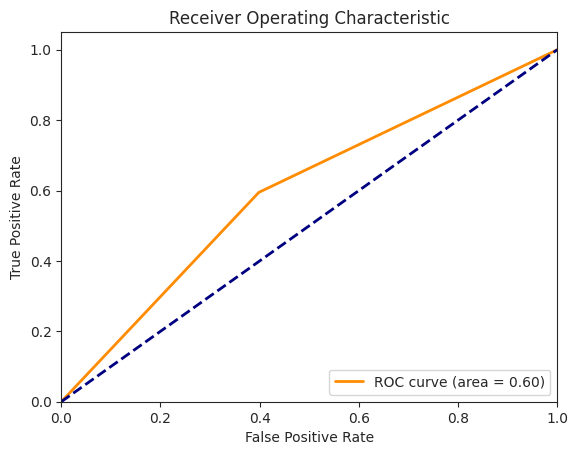

In [19]:
interval_dict = get_length_dist(ml_df)
P = 0
N = 0
TP = 0
TN = 0
FP = 0
FN = 0


# Initialize arrays to store all predicted scores and actual labels
all_pred_scores = []
all_actual_labels = []

for seq in ml_df["Sequence"]:
    pred = pred_seq(seq, inerval_dict=interval_dict)
    actual_label = ml_df[ml_df["Sequence"] == seq]["Label"][0]
    if (pred, actual_label) == (1,1):
        TP += 1
        P += 1
    if (pred, actual_label) == (1,-1):
        FP += 1
        P+=1
    if (pred, actual_label) == (-1,1):
        FN+=1
        N+=1
    if (pred, actual_label) == (-1,-1):
        TN+=1
        N+=1

    all_pred_scores.append(pred)
    all_actual_labels.append(actual_label)


sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / len(ml_df)
precision = TP / (TP + TN)
f_1 = 2* ((precision * sensitivity) / (precision + sensitivity))

# Calculate ROC curve and AUC for the entire dataset
fpr, tpr, thresholds = roc_curve(all_actual_labels, all_pred_scores)
roc_auc = auc(fpr, tpr)

# Print the ROC curve values
print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()







In [3]:
scores = open(f"test_scores.tsv", "w")
tmp = []
for i in [1,2,3]:
    tmp.append(str(i))
scores.write("\t".join(tmp))
scores.close()